In [168]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from scipy.stats import linregress
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dense
from keras.models import model_from_yaml

# ㅤㅤㅤㅤㅤㅤㅤㅤПодготовка данных и создание выборок
Буду рассматривать 3 степени зашумленности сигнала и для каждого шума буду создавать модель.
Можно ещё тренировать модели по дальности прогноза, но тогда их будет слишком много. Поэтому буду делать прогноз по оси x на 0.3, другими словами, буду прогнозировать третье значение после входных данных.

Мой подход к задаче таков: 

        

1) Создание скользящей средней, чтобы хоть как-то минимизировать шум


2) Подавать во входной слой 3 признака: ema[n-2], ema[n-1], ema[n]. Сделал это для того, чтобы была отслежена динамика     изменения ema. Потому что если просто подавать значения ema[n], признак может быть неправильно                   интерпретирован. Например, на закруглении синуса у него значения ближе к единице. И если подать просто значения 0.9,       то будет непонятно эта 0.9 во время убывающего тренда или повышающегося.

In [169]:
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)


# Написал функцию, чтобы для каждого шума не писать одно и то же
def create_data(data, n, name):   

    #Логика рассчета скопирована из примера в черновике
    
    #Рассчет MA и удаление элементов в начале output_data, тк MA для первых n-1 элементов не рассчитывается
    data_ema = moving_avg(data, n)
    output_data = data[n-1:]
    
    #Сдвиг MA для получения  значений входного вектора 
    roll_1 = np.roll(data_ema, 1)
    roll_2 = np.roll(data_ema, 2)
    
    #Объединение во входной вектор
    input_data = np.stack((roll_2, roll_1, data_ema), axis=1)

    # Удаление первых двух элементов из-за сдвига
    input_data, output_data  = input_data[2:], output_data[2:]
    
    #Удаление последних и первых 63 элементов, чтобы вектора соответствовали друг другу по длине и смыслу (2pi | 0.1 = ~63)
    input_data, output_data = input_data[:len(input_data)-63], output_data[63:]


    # ~50% данных в обучающую выборку, ~25% на валидацию, ~25% на тестовую 
    input_train, input_test = input_data[:1500], input_data[1500:]
    output_train, output_test = output_data[:1500], output_data[1500:]
    
    #Сохранение в csv
    np.savetxt('input_train_' + name + '.csv', input_train, delimiter=',')
    np.savetxt('input_test_' + name + '.csv', input_test, delimiter=',')
    
    np.savetxt('output_train_' + name + '.csv', output_train, delimiter=',')
    np.savetxt('output_test_' + name + '.csv', output_test, delimiter=',')
    

    
#Создание массива значений синуса с шагом 0.1
x = np.arange(0, 200, 0.1)
sin = np.sin(x)

#Создание шума с разным отклонением
sin_with_noise_0_1  = sin + np.random.normal(0, 0.1, sin.shape)
sin_with_noise_0_3  = sin + np.random.normal(0, 0.3, sin.shape)
sin_with_noise_0_5  = sin + np.random.normal(0, 0.5, sin.shape)    

    
create_data(sin_with_noise_0_1, 8, 'sin_with_noise_0_1')    
create_data(sin_with_noise_0_3, 8, 'sin_with_noise_0_3') 
create_data(sin_with_noise_0_5, 8, 'sin_with_noise_0_5') 

#Сохранил также и то что сгенерировал во время написания этого кода 
np.savetxt('sin_with_noise_0_1.csv', sin_with_noise_0_1, delimiter=',')
np.savetxt('sin_with_noise_0_3.csv', sin_with_noise_0_3, delimiter=',')
np.savetxt('sin_with_noise_0_5.csv', sin_with_noise_0_5, delimiter=',')
    
  

Небольшой комментарий: не увидел большого смысла стандартизировать данные, так как рассматриваем только сам зашумленный синус и производные от него данные (Он и так колеблется от -1 до 1, с шумом, конечно, больше. При минимаксной нормализации все равно будут аномальные значения, а Z нормализация немного имеет смысл, но разгон чисел все равно мал. Поэтому тут как посмотреть). Совсем другое дело, когда в модели множество признаков, у которых значения сильно различаются. Так как в противном случае у модели не будет сходимости

# ㅤㅤㅤㅤㅤㅤㅤㅤОтображение сгенерированных данных

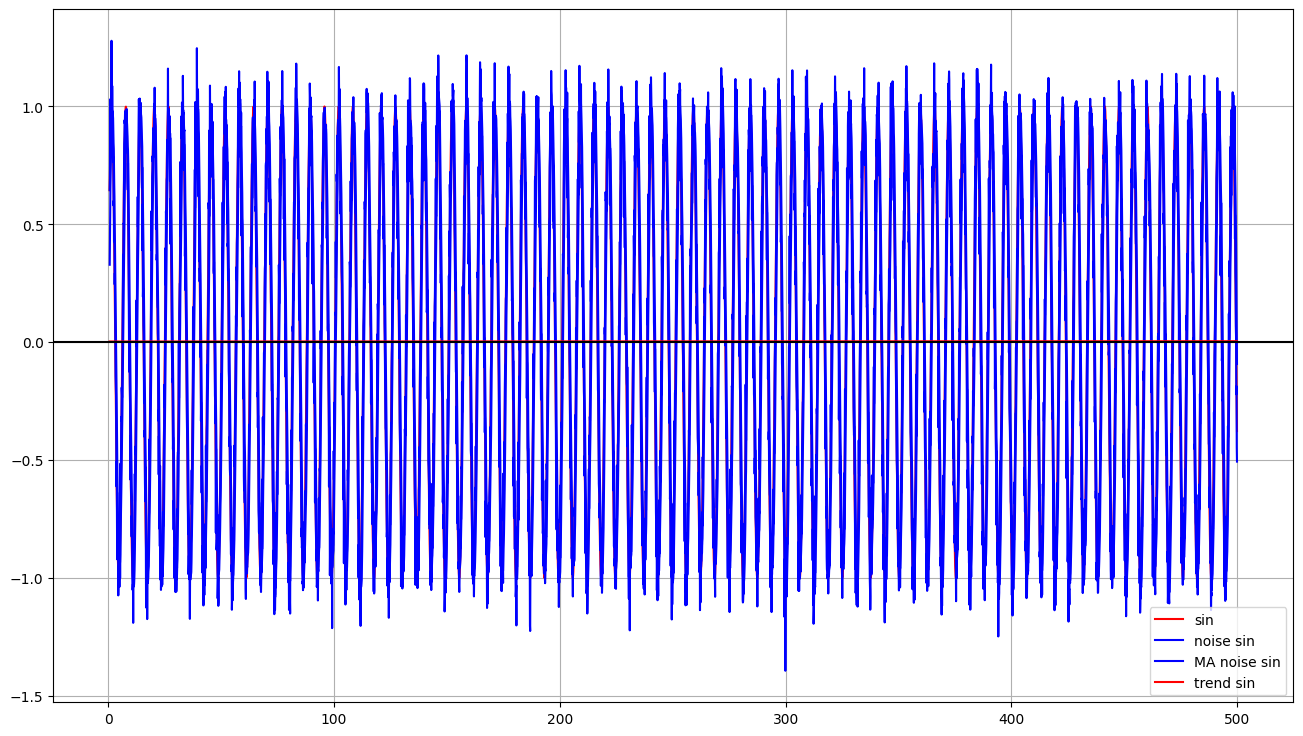

In [258]:
#График зашумленного сигнала, а также линия тренда, рассчитанная МНК (оранжевая), в сравнении с красной горизонтальной 
# линией, которая идет чётко по нулю
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)


x = np.arange(0, 500, 0.1)
sin = np.sin(x)
sin_with_noise  = sin + np.random.normal(0, 0.1, sin.shape)

n = 8
sin_with_noise_ema = moving_avg(sin_with_noise, n)


x, sin, sin_with_noise = x[n-1: ], sin[n-1: ], sin_with_noise[n-1: ]


#МОЖНО РАСКОМЕНТИТЬ, ЧТОБЫ РАССМОТРЕТЬ БОЛЕЕ ДЕТАЛЬНО
# x, sin, sin_with_noise, sin_with_noise_ema = x[len(x)-200: ], sin[len(x)-200: ], sin_with_noise[len(x)-200: ], sin_with_noise_ema[len(x)-200: ]

plt.figure(figsize=(16, 9))

#Отображение синуса
plt.plot(x, sin, color = 'r', label='sin')

plt.legend(['sin'])

#Отображение зашумленного синуса 
plt.plot(x, sin_with_noise, color = 'b', label='noise sin')



#Скользящая средняя к зашумленному синусу
plt.plot(x, sin_with_noise_ema, color = 'b', label='MA noise sin')


#Рассчет и отображение линии тренда синуса

slope, intercept, r_value, p_value, std_err = linregress(x, sin)

plt.plot(x, intercept + slope*x, color = 'r', label='trend sin')

#Рассчет и отображение линии тренда зашумленного синуса



#Прмая, проходящая по нулю
plt.axhline(y = 0, color = 'k')

plt.legend(['sin', 'noise sin', 'MA noise sin', 'trend sin'])

plt.grid()

plt.show()



# ㅤㅤㅤㅤОбучение модели способом 1 (с помощью модели LSTM) 
Данная модель была выбрана потому что если смотреть развертку LSTM, то там будут "хранится" её предыдущие состояния. Учитывая, что ряд у нас цикличный, то благодаря данной модели задача должна быть легко решаемой. 

Использовал среднеквадратичную ошибку в качестве функции потерь, так как она оценивает расстояние между сделанным прогнозом и целевым значением (а если точнее это сумма квадратов разности расстояний деленная на период, так сказать "средняя температура по больнице")

По хорошему, в самом начале обучения, нужно создавать сразу несколько одинаковых моделей  с разными начальными весами  и смотреть как они обучаются, так как у НС на основе метода back propagation есть особенность попадать в локальный минимум по функции потерь.

Для такой задачи нет смысла создавать много слоёв с большим количеством нейронов, так как она простая довольно. Да и в целом нужно создавать слоев и нейронов столько, сколько это необходимо, так как излишнее количество только ухудшает обучение и сильнее нагружает вычисления.

Можно было бы оставить и просто LSTM слой, но так как у него по дефолту функция активации гиперболический тангенс, насколько я помню, то значения будут от -1 до 1, а у нас при шуме значения бывают и больше 1, поэтому нам нужен дополнительный слой с линейной функции активации для числового предсказания шума 

Хотел, кстати, создать чекпоинты (чтобы ловить моменты переобучения и работать от этих точек) по эпохам, например, каждые 10 эпох, но немного не понял как. В итоге оставил эту затею, так как на сравнении тренировочной и валидационной выборки не увидел переобучения. Лосс фнукция валидационной выборки не шла наверх. Это ещё нужно на всякий случай, вдруг что случится, например, ноутбук забыл на зарядку поставить, а он во время обучения отключится. 

В качестве второй метрики оценивания выбрал MAE, так как он устойчив к данным с выбросами (хоть он и никак не влияет на обучение, тк не выбран в качестве лосс функции). 

In [208]:
# Загрузка данных 
name = 'sin_with_noise_0_5'

train_input = np.genfromtxt('input_train_' + name + '.csv', delimiter=',')
train_output = np.genfromtxt('output_train_' + name + '.csv', delimiter=',')

test_input = np.genfromtxt('input_test_' + name + '.csv', delimiter=',')
test_output = np.genfromtxt('output_test_' + name + '.csv', delimiter=',')

In [209]:
model = Sequential([
    LSTM(units = 8,  input_shape = (3,1)),
    Dense(8, activation='linear'),
    Dense(1, activation='linear')
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics= ['mean_absolute_error'])


history = model.fit(train_input, train_output, epochs=120, validation_split=0.3)

Epoch 1/120
33/33 [==============================] - 2s 15ms/step - loss: 0.7755 - mean_absolute_error: 0.7283 - val_loss: 0.5997 - val_mean_absolute_error: 0.6352
Epoch 2/120
33/33 [==============================] - 0s 4ms/step - loss: 0.5609 - mean_absolute_error: 0.6065 - val_loss: 0.4442 - val_mean_absolute_error: 0.5338
Epoch 3/120
33/33 [==============================] - 0s 4ms/step - loss: 0.4486 - mean_absolute_error: 0.5334 - val_loss: 0.3769 - val_mean_absolute_error: 0.4878
Epoch 4/120
33/33 [==============================] - 0s 4ms/step - loss: 0.4094 - mean_absolute_error: 0.5070 - val_loss: 0.3635 - val_mean_absolute_error: 0.4785
Epoch 5/120
33/33 [==============================] - 0s 4ms/step - loss: 0.4030 - mean_absolute_error: 0.5037 - val_loss: 0.3604 - val_mean_absolute_error: 0.4767
Epoch 6/120
33/33 [==============================] - 0s 4ms/step - loss: 0.4012 - mean_absolute_error: 0.5027 - val_loss: 0.3594 - val_mean_absolute_error: 0.4765
Epoch 7/120
33/33 [==

33/33 [==============================] - 0s 4ms/step - loss: 0.3800 - mean_absolute_error: 0.4898 - val_loss: 0.3378 - val_mean_absolute_error: 0.4611
Epoch 52/120
33/33 [==============================] - 0s 4ms/step - loss: 0.3786 - mean_absolute_error: 0.4896 - val_loss: 0.3374 - val_mean_absolute_error: 0.4609
Epoch 53/120
33/33 [==============================] - 0s 4ms/step - loss: 0.3776 - mean_absolute_error: 0.4888 - val_loss: 0.3371 - val_mean_absolute_error: 0.4607
Epoch 54/120
33/33 [==============================] - 0s 4ms/step - loss: 0.3772 - mean_absolute_error: 0.4890 - val_loss: 0.3358 - val_mean_absolute_error: 0.4596
Epoch 55/120
33/33 [==============================] - 0s 4ms/step - loss: 0.3760 - mean_absolute_error: 0.4877 - val_loss: 0.3353 - val_mean_absolute_error: 0.4593
Epoch 56/120
33/33 [==============================] - 0s 4ms/step - loss: 0.3761 - mean_absolute_error: 0.4872 - val_loss: 0.3350 - val_mean_absolute_error: 0.4591
Epoch 57/120
33/33 [=========

33/33 [==============================] - 0s 4ms/step - loss: 0.3479 - mean_absolute_error: 0.4696 - val_loss: 0.3087 - val_mean_absolute_error: 0.4419
Epoch 102/120
33/33 [==============================] - 0s 4ms/step - loss: 0.3444 - mean_absolute_error: 0.4684 - val_loss: 0.3124 - val_mean_absolute_error: 0.4448
Epoch 103/120
33/33 [==============================] - 0s 4ms/step - loss: 0.3448 - mean_absolute_error: 0.4662 - val_loss: 0.3065 - val_mean_absolute_error: 0.4403
Epoch 104/120
33/33 [==============================] - 0s 4ms/step - loss: 0.3450 - mean_absolute_error: 0.4667 - val_loss: 0.3065 - val_mean_absolute_error: 0.4405
Epoch 105/120
33/33 [==============================] - 0s 4ms/step - loss: 0.3461 - mean_absolute_error: 0.4675 - val_loss: 0.3062 - val_mean_absolute_error: 0.4401
Epoch 106/120
33/33 [==============================] - 0s 4ms/step - loss: 0.3441 - mean_absolute_error: 0.4670 - val_loss: 0.3079 - val_mean_absolute_error: 0.4412
Epoch 107/120
33/33 [===

In [228]:
#Функции для построения графиков

def plot_mse():
    # Обучение и проверка величины потерь
    plt.figure(figsize=(16, 9))   
        
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')

    plt.title('MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'])

    plt.show()
    
def plot_msa():
    # Обучение и проверка величины потерь
    plt.figure(figsize=(16, 9))
    
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')

    plt.title('MSA')
    plt.ylabel('MSA')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'])

    plt.show()
    
    
    
    
def show_pred(name, type_model):
    model = keras.models.load_model('model_' + type_model + '_'+name)

    def moving_avg(x, n):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[n:] - cumsum[:-n]) / float(n)


    input_test = np.genfromtxt('input_test_' + name + '.csv', delimiter=',')
    sin_with_noise = np.genfromtxt('output_test_' + name + '.csv', delimiter=',')



    predictions = model.predict(input_test)

    x = np.arange(0, len(sin_with_noise)*0.1, 0.1)  

    
    n = 8
    sin_with_noise_ema = moving_avg(sin_with_noise, n)
    x, sin_with_noise, predictions = x[n-1: ], sin_with_noise[n-1: ], predictions[n-1: ]



     #Показ последних 150 точек, можно закомментитить при желании
    x, sin_with_noise_ema, sin_with_noise, predictions = x[len(x)-150 :], sin_with_noise_ema[len(x)-150 :], sin_with_noise[len(x)-150 :], predictions[len(x)-150 :]


    plt.figure(figsize=(16, 9))

    #Отображение предсказаний
    plt.plot(x, predictions, color = 'r', label='prediction')


    #Отображение зашумленного синуса 
    plt.plot(x, sin_with_noise, color = 'b', label='noise sin')



    #Скользящая средняя к зашумленному синусу
    plt.plot(x, sin_with_noise_ema, color = 'g', label='MA noise sin')


    #Прмая, проходящая по нулю
    plt.axhline(y = 0, color = 'k')

    plt.legend(['prediction', 'noise sin', 'MA noise sin'])

    plt.grid()

    plt.show()    

### Модель с LSTM для 'sin_with_noise_0_1'

In [192]:
model.evaluate(test_input, test_output)
model.save('model_LSTM_'+name)

14/14 [==============================] - 0s 2ms/step - loss: 0.0141 - mean_absolute_error: 0.0934
INFO:tensorflow:Assets written to: model_LSTM_sin_with_noise_0_1\assets


INFO:tensorflow:Assets written to: model_LSTM_sin_with_noise_0_1\assets


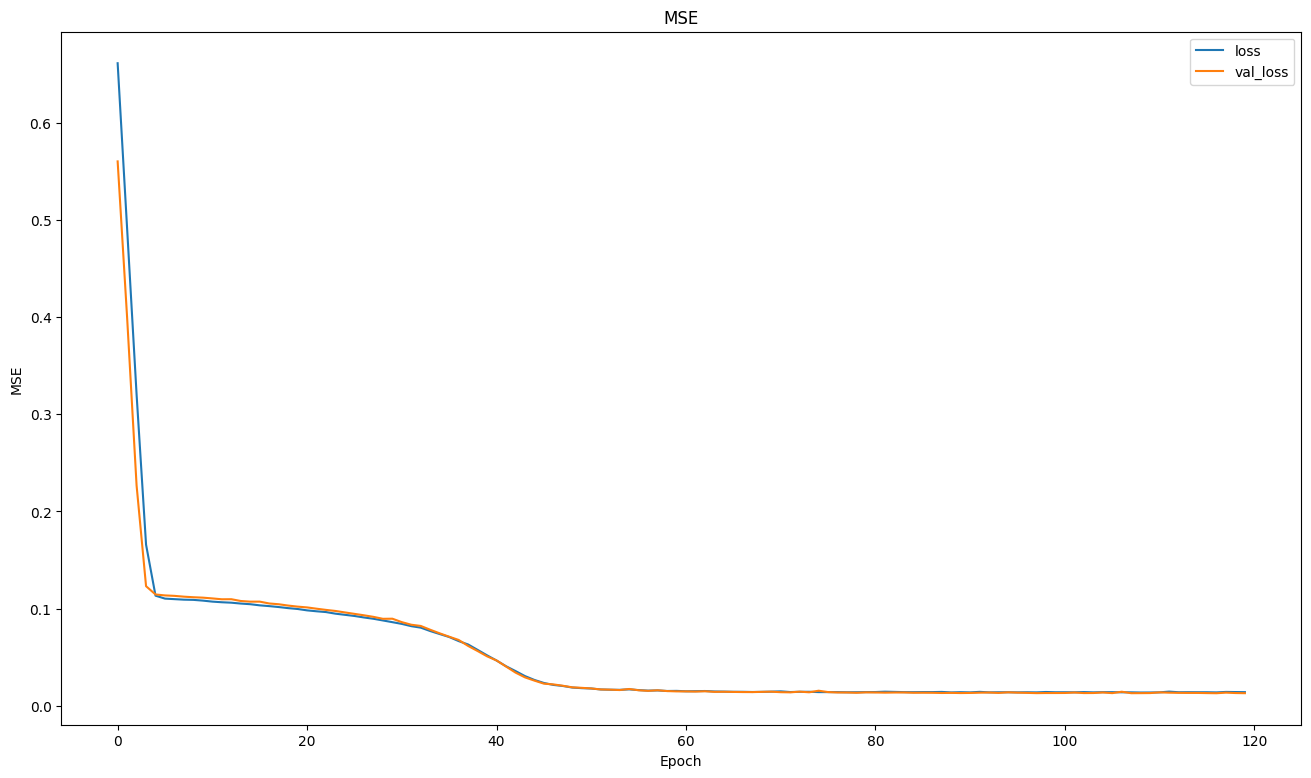

In [193]:
plot_mse()

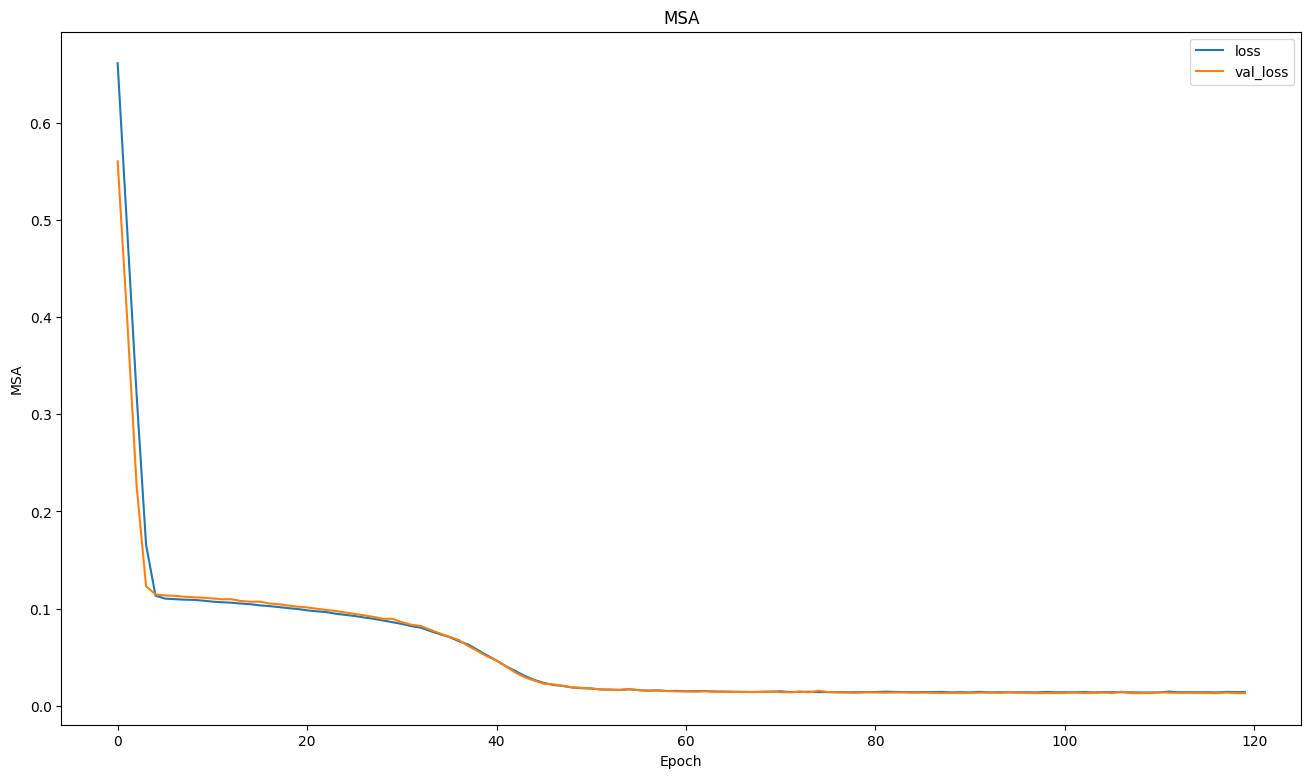

In [194]:
plot_msa()

14/14 [==============================] - 0s 1ms/step


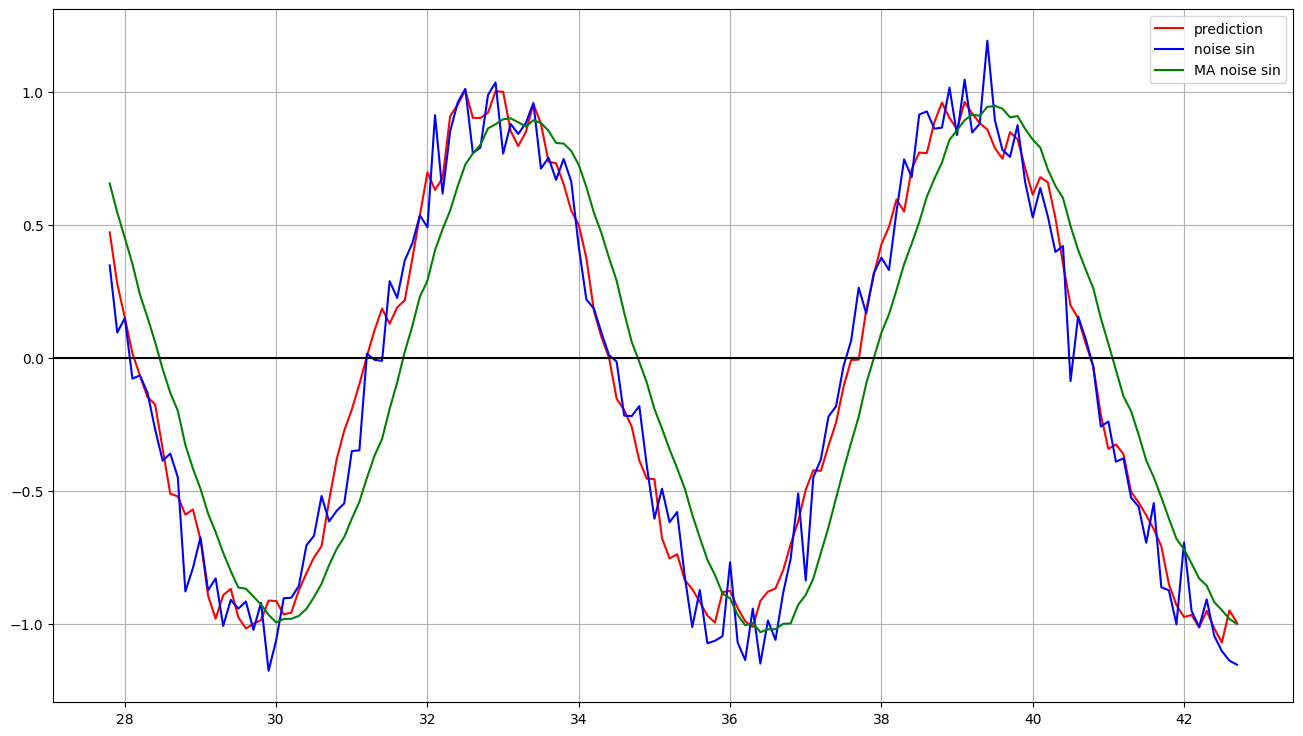

In [230]:
name = 'sin_with_noise_0_1'
type_model = 'LSTM' 
show_pred(name, type_model)

### Модель с LSTM для 'sin_with_noise_0_3'

In [204]:
model.evaluate(test_input, test_output)
model.save('model_LSTM_'+name)

14/14 [==============================] - 0s 2ms/step - loss: 0.1152 - mean_absolute_error: 0.2717
INFO:tensorflow:Assets written to: model_LSTM_sin_with_noise_0_3\assets


INFO:tensorflow:Assets written to: model_LSTM_sin_with_noise_0_3\assets


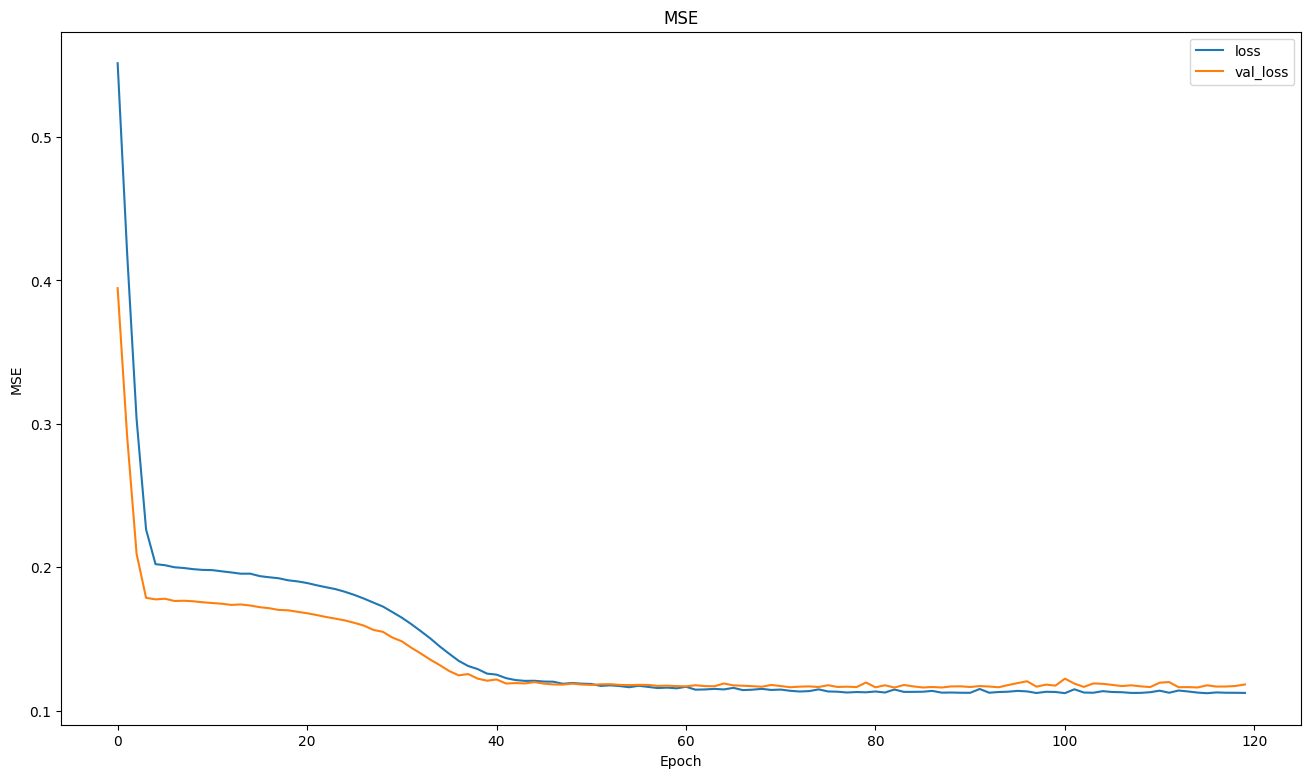

In [205]:
plot_mse()

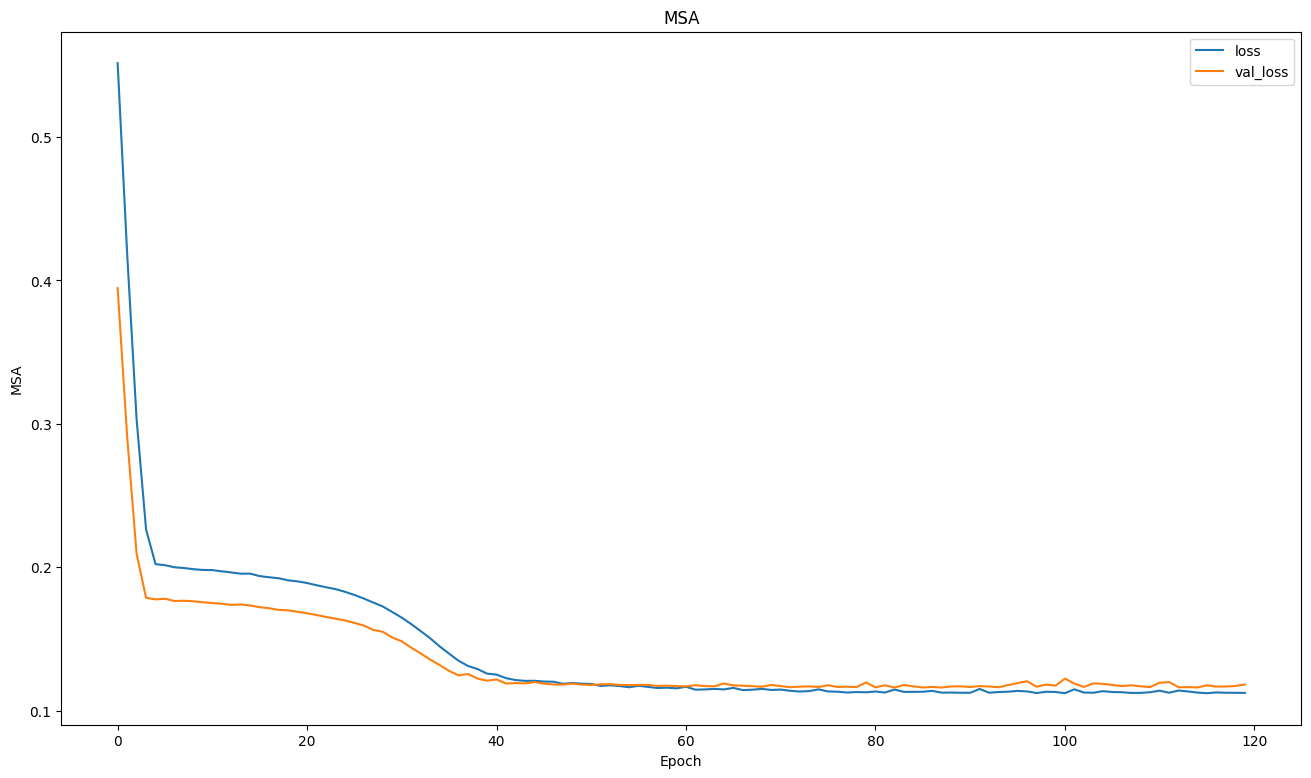

In [206]:
plot_msa()

14/14 [==============================] - 0s 2ms/step


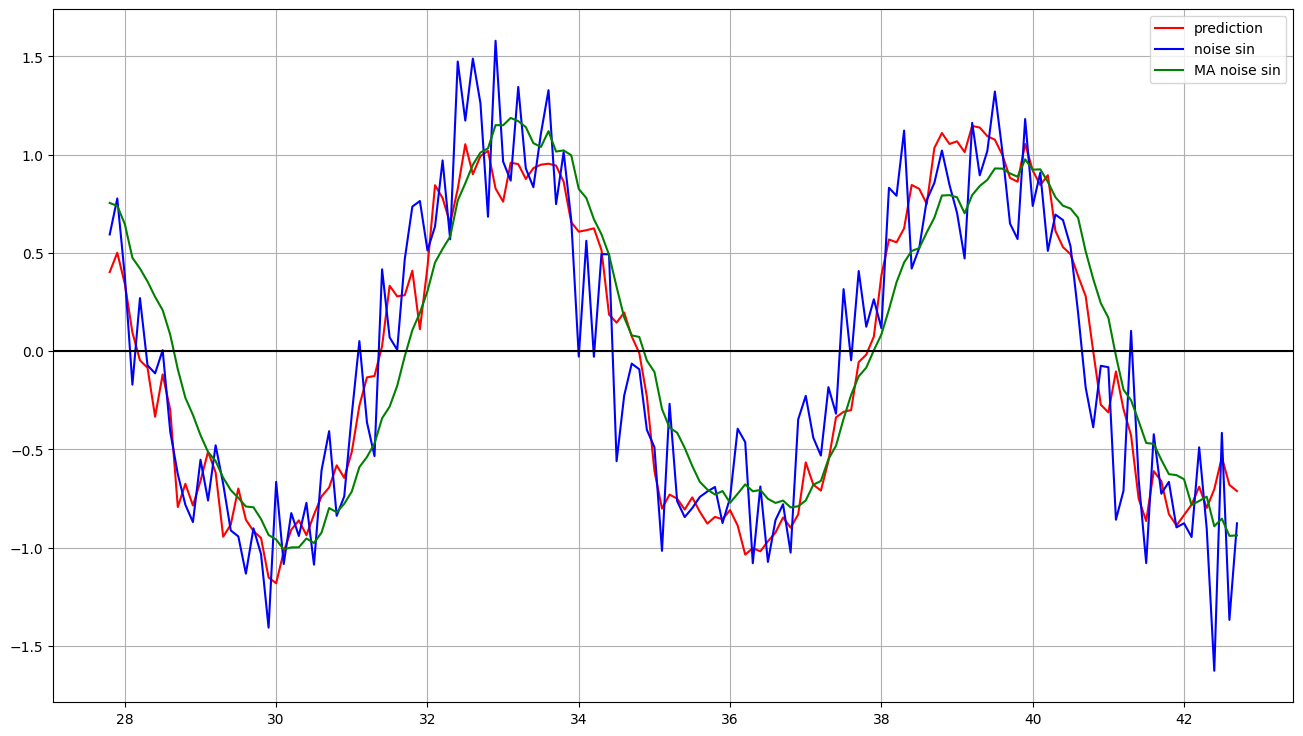

In [231]:
name = 'sin_with_noise_0_3'
type_model = 'LSTM' 
show_pred(name, type_model)

### Модель с LSTM для 'sin_with_noise_0_5'

In [211]:
model.evaluate(test_input, test_output)
model.save('model_LSTM_'+name)

14/14 [==============================] - 0s 2ms/step - loss: 0.3115 - mean_absolute_error: 0.4484
INFO:tensorflow:Assets written to: model_LSTM_sin_with_noise_0_5\assets


INFO:tensorflow:Assets written to: model_LSTM_sin_with_noise_0_5\assets


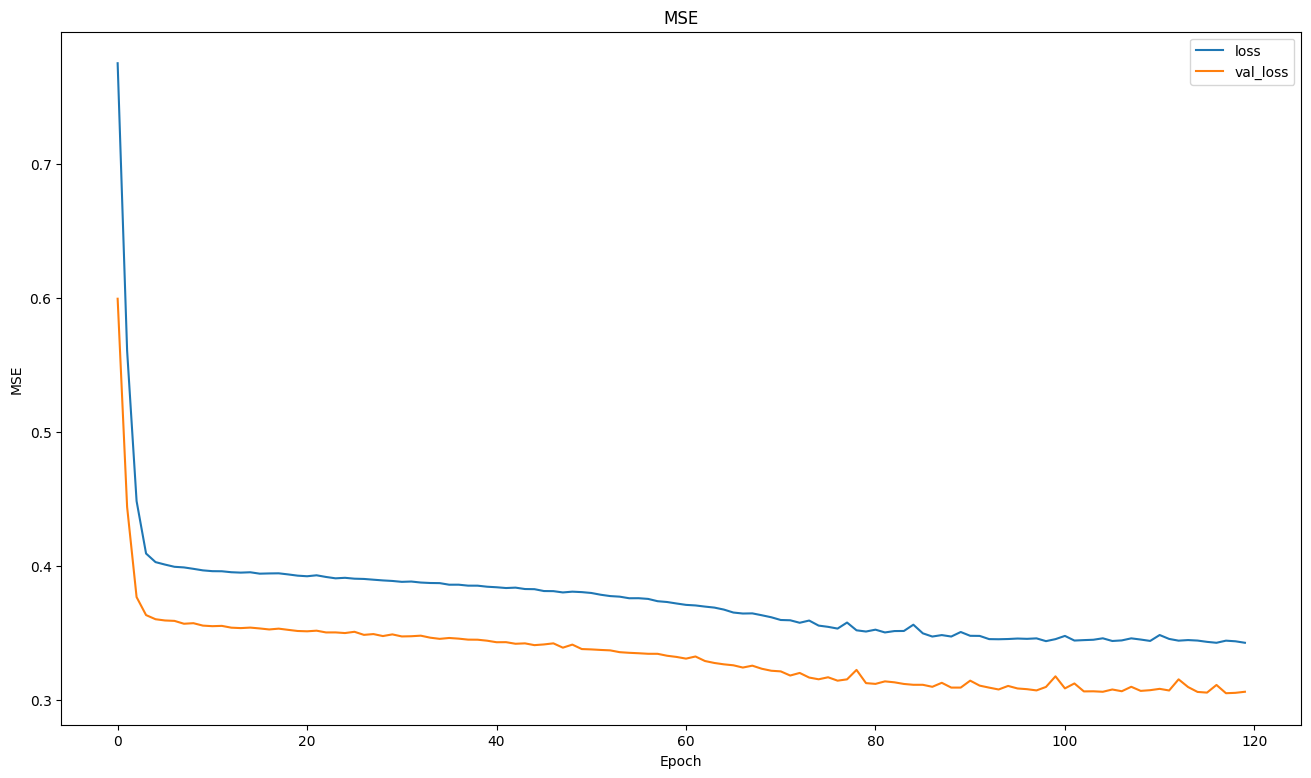

In [212]:
plot_mse()

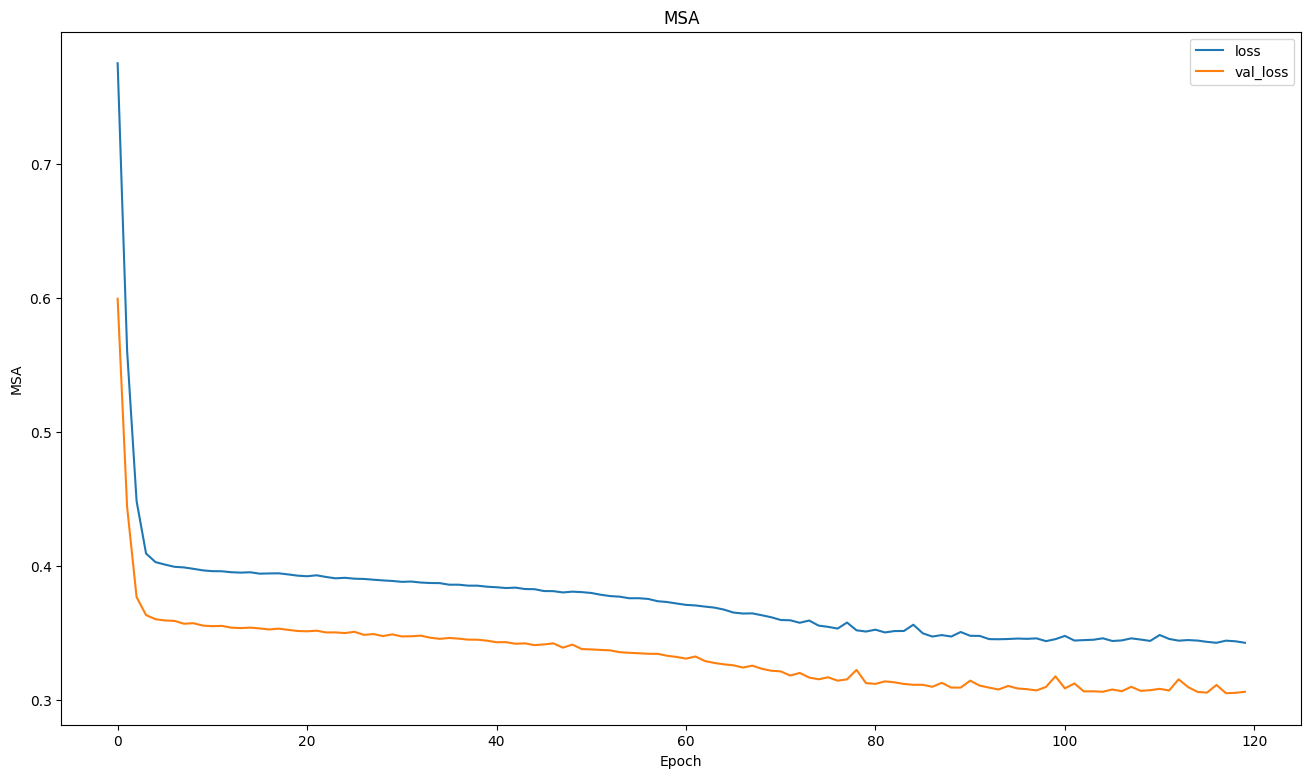

In [213]:
plot_msa()

14/14 [==============================] - 0s 2ms/step


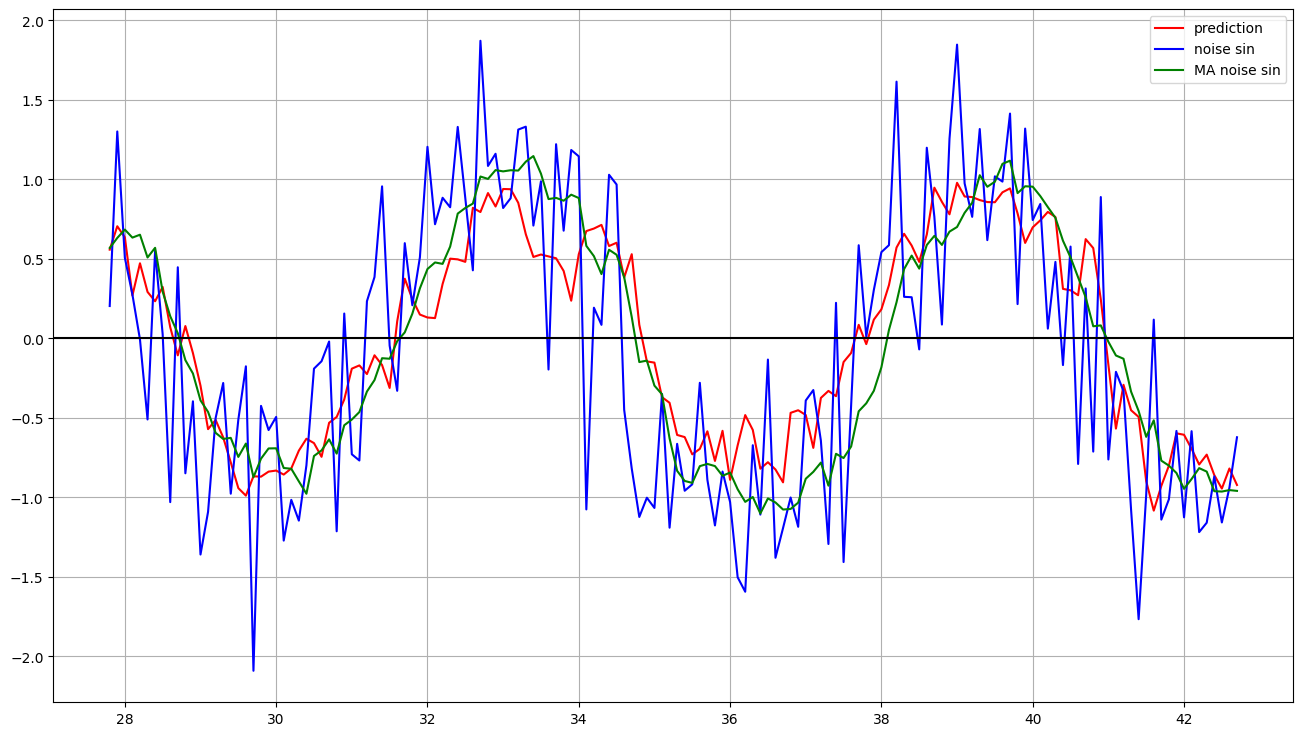

In [232]:
name = 'sin_with_noise_0_5'
type_model = 'LSTM' 
show_pred(name, type_model)

# ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤОбучение модели способом 2 (RNN) 
Я не стал пробовать предсказать с помощью многослойного перцептрона (читал давно где-то), так как при такой задаче такие модели не обучаются из-за сквозной линейной зависимости слоев. Поэтому решил сравнить с простой RNN моделью и сравнить результаты.

In [215]:
#Функции для построения графиков

def plot_mse():
    # Обучение и проверка величины потерь
    plt.figure(figsize=(16, 9))   
        
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')

    plt.title('MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'])

    plt.show()
    
def plot_msa():
    # Обучение и проверка величины потерь
    plt.figure(figsize=(16, 9))
    
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')

    plt.title('MSA')
    plt.ylabel('MSA')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'])

    plt.show()
    
    
    
    
def show_pred(name, type_model):
    model = keras.models.load_model('model_' + type_model + '_'+name)

    def moving_avg(x, n):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[n:] - cumsum[:-n]) / float(n)


    input_test = np.genfromtxt('input_test_' + name + '.csv', delimiter=',')
    sin_with_noise = np.genfromtxt('output_test_' + name + '.csv', delimiter=',')



    predictions = model.predict(input_test)

    x = np.arange(0, len(sin_with_noise)*0.1, 0.1)  

    
    n = 8
    sin_with_noise_ema = moving_avg(sin_with_noise, n)
    x, sin_with_noise, predictions = x[n-1: ], sin_with_noise[n-1: ], predictions[n-1: ]



     #Показ последних 150 точек, можно закомментитить при желании
    x, sin_with_noise_ema, sin_with_noise, predictions = x[len(x)-150 :], sin_with_noise_ema[len(x)-150 :], sin_with_noise[len(x)-150 :], predictions[len(x)-150 :]


    plt.figure(figsize=(16, 9))

    #Отображение предсказаний
    plt.plot(x, predictions, color = 'r', label='prediction')


    #Отображение зашумленного синуса 
    plt.plot(x, sin_with_noise, color = 'b', label='noise sin')



    #Скользящая средняя к зашумленному синусу
    plt.plot(x, sin_with_noise_ema, color = 'g', label='MA noise sin')


    #Прмая, проходящая по нулю
    plt.axhline(y = 0, color = 'k')

    plt.legend(['sin', 'noise sin', 'MA noise sin'])

    plt.grid()

    plt.show()    

In [251]:
# Загрузка данных 
name = 'sin_with_noise_0_5'

train_input = np.genfromtxt('input_train_' + name + '.csv', delimiter=',')
train_output = np.genfromtxt('output_train_' + name + '.csv', delimiter=',')

test_input = np.genfromtxt('input_test_' + name + '.csv', delimiter=',')
test_output = np.genfromtxt('output_test_' + name + '.csv', delimiter=',')

In [252]:
model = Sequential([
    SimpleRNN(units = 8, input_shape = (3,1)),
    Dense(8, activation='linear'),
    Dense(1, activation='linear')
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics= ['mean_absolute_error'])


history = model.fit(train_input, train_output, epochs=120, validation_split=0.3)

Epoch 1/120
33/33 [==============================] - 1s 8ms/step - loss: 1.3832 - mean_absolute_error: 0.9934 - val_loss: 0.7921 - val_mean_absolute_error: 0.7455
Epoch 2/120
33/33 [==============================] - 0s 3ms/step - loss: 0.5927 - mean_absolute_error: 0.6247 - val_loss: 0.3951 - val_mean_absolute_error: 0.5002
Epoch 3/120
33/33 [==============================] - 0s 3ms/step - loss: 0.4009 - mean_absolute_error: 0.5025 - val_loss: 0.3426 - val_mean_absolute_error: 0.4651
Epoch 4/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3826 - mean_absolute_error: 0.4897 - val_loss: 0.3403 - val_mean_absolute_error: 0.4638
Epoch 5/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3789 - mean_absolute_error: 0.4873 - val_loss: 0.3370 - val_mean_absolute_error: 0.4615
Epoch 6/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3756 - mean_absolute_error: 0.4853 - val_loss: 0.3339 - val_mean_absolute_error: 0.4591
Epoch 7/120
33/33 [===

33/33 [==============================] - 0s 3ms/step - loss: 0.3461 - mean_absolute_error: 0.4678 - val_loss: 0.3062 - val_mean_absolute_error: 0.4408
Epoch 52/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3452 - mean_absolute_error: 0.4666 - val_loss: 0.3058 - val_mean_absolute_error: 0.4407
Epoch 53/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3464 - mean_absolute_error: 0.4673 - val_loss: 0.3059 - val_mean_absolute_error: 0.4407
Epoch 54/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3451 - mean_absolute_error: 0.4674 - val_loss: 0.3058 - val_mean_absolute_error: 0.4405
Epoch 55/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3458 - mean_absolute_error: 0.4677 - val_loss: 0.3072 - val_mean_absolute_error: 0.4414
Epoch 56/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3451 - mean_absolute_error: 0.4658 - val_loss: 0.3073 - val_mean_absolute_error: 0.4417
Epoch 57/120
33/33 [=========

33/33 [==============================] - 0s 3ms/step - loss: 0.3449 - mean_absolute_error: 0.4658 - val_loss: 0.3048 - val_mean_absolute_error: 0.4395
Epoch 102/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3424 - mean_absolute_error: 0.4649 - val_loss: 0.3087 - val_mean_absolute_error: 0.4424
Epoch 103/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3452 - mean_absolute_error: 0.4661 - val_loss: 0.3049 - val_mean_absolute_error: 0.4396
Epoch 104/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3435 - mean_absolute_error: 0.4644 - val_loss: 0.3072 - val_mean_absolute_error: 0.4410
Epoch 105/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3450 - mean_absolute_error: 0.4663 - val_loss: 0.3056 - val_mean_absolute_error: 0.4401
Epoch 106/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3447 - mean_absolute_error: 0.4666 - val_loss: 0.3057 - val_mean_absolute_error: 0.4403
Epoch 107/120
33/33 [===

### Модель RNN  для 'sin_with_noise_0_1'

In [218]:
model.evaluate(test_input, test_output)
model.save('model_RNN_'+name)

14/14 [==============================] - 0s 1ms/step - loss: 0.0137 - mean_absolute_error: 0.0929
INFO:tensorflow:Assets written to: model_RNN_sin_with_noise_0_1\assets


INFO:tensorflow:Assets written to: model_RNN_sin_with_noise_0_1\assets


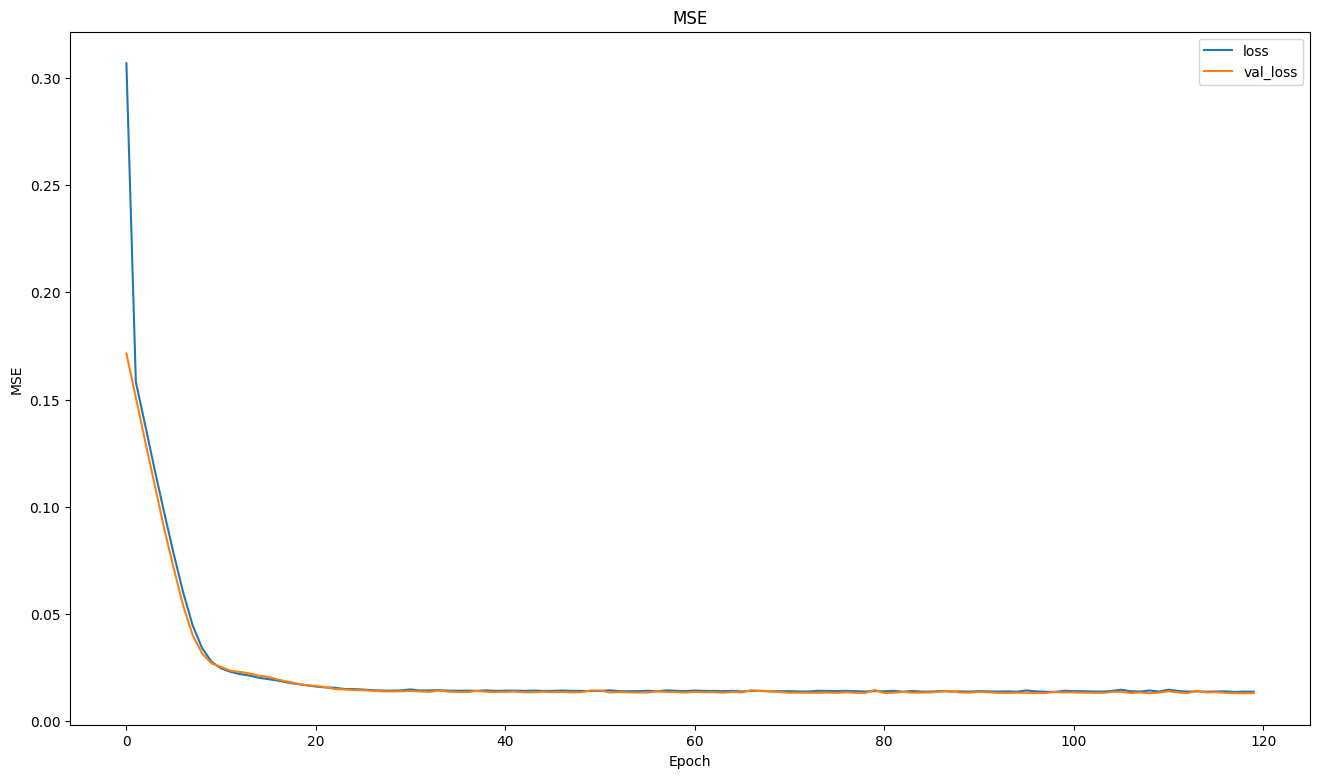

In [219]:
plot_mse()

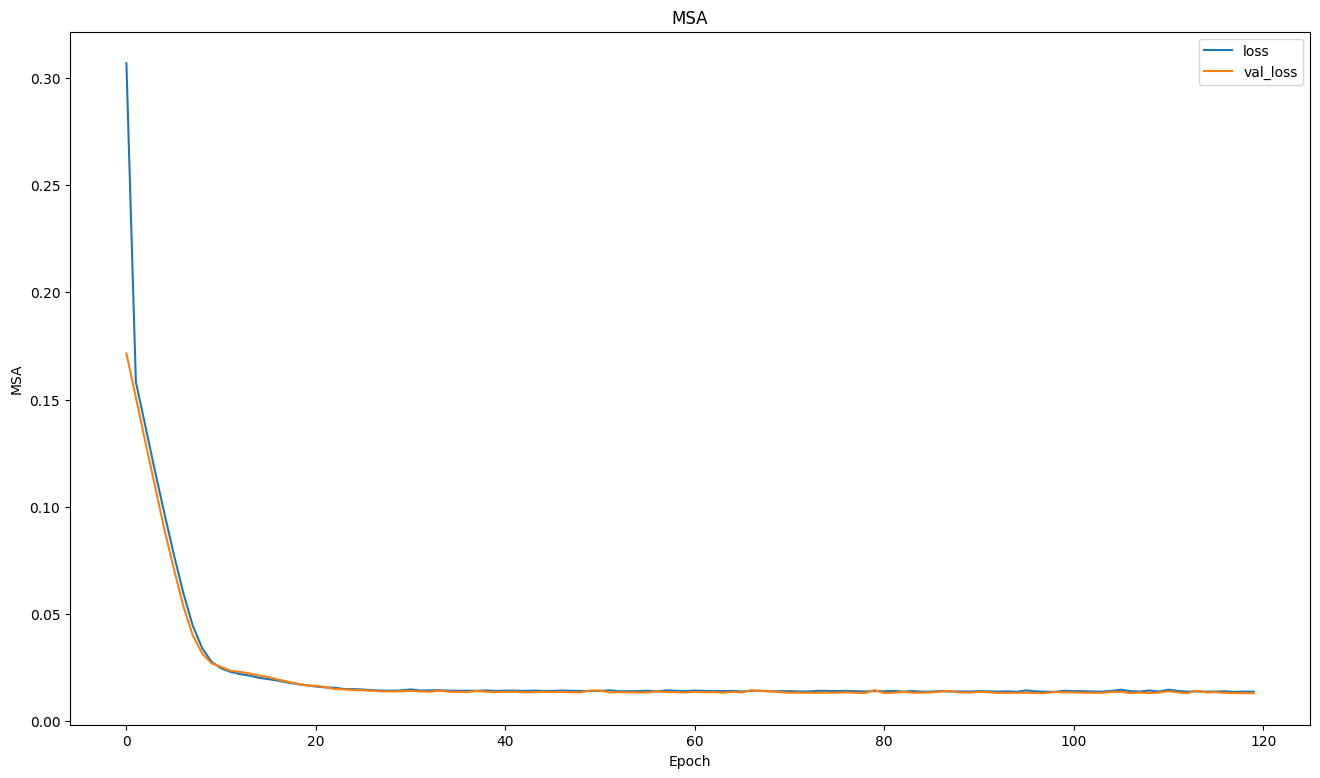

In [220]:
plot_msa()

14/14 [==============================] - 0s 1ms/step


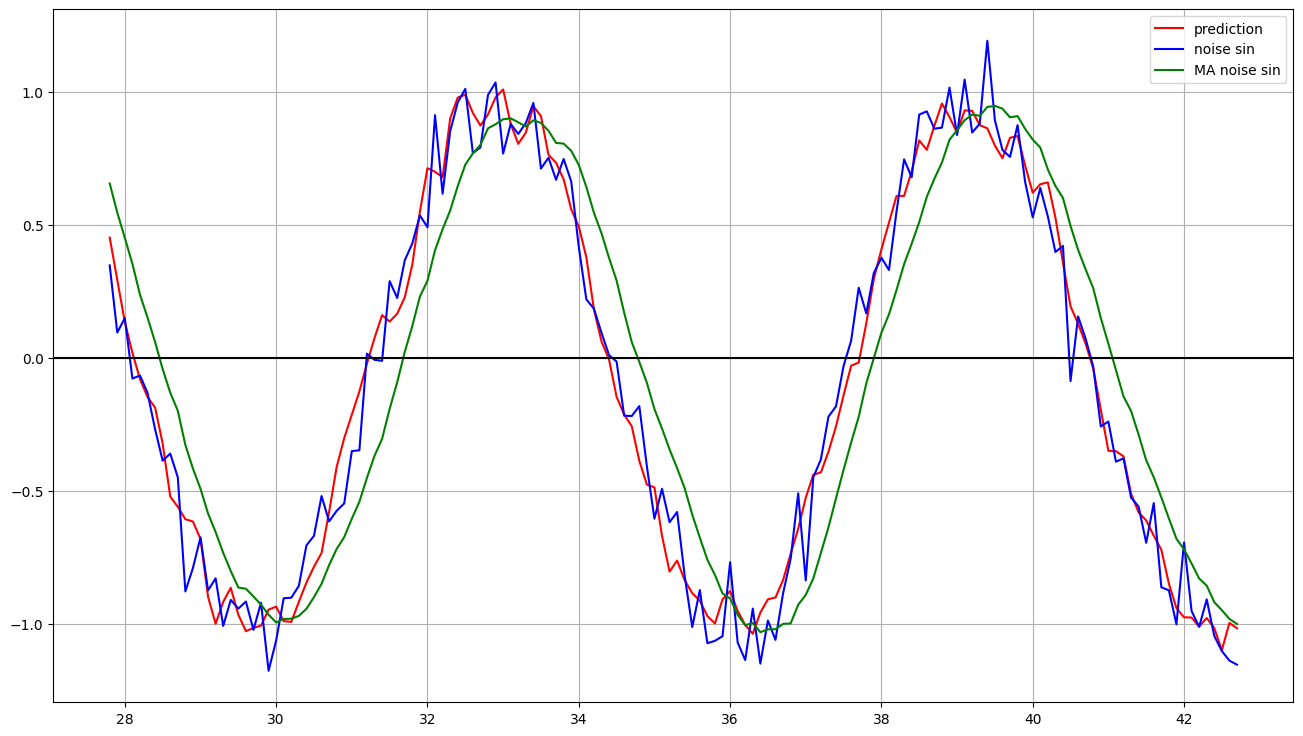

In [235]:
name = 'sin_with_noise_0_1'
type_model = 'RNN' 
show_pred(name, type_model)

### Модель RNN  для 'sin_with_noise_0_3'

In [238]:
model.evaluate(test_input, test_output)
model.save('model_RNN_'+name)

14/14 [==============================] - 0s 1ms/step - loss: 0.1148 - mean_absolute_error: 0.2706
INFO:tensorflow:Assets written to: model_RNN_sin_with_noise_0_3\assets


INFO:tensorflow:Assets written to: model_RNN_sin_with_noise_0_3\assets


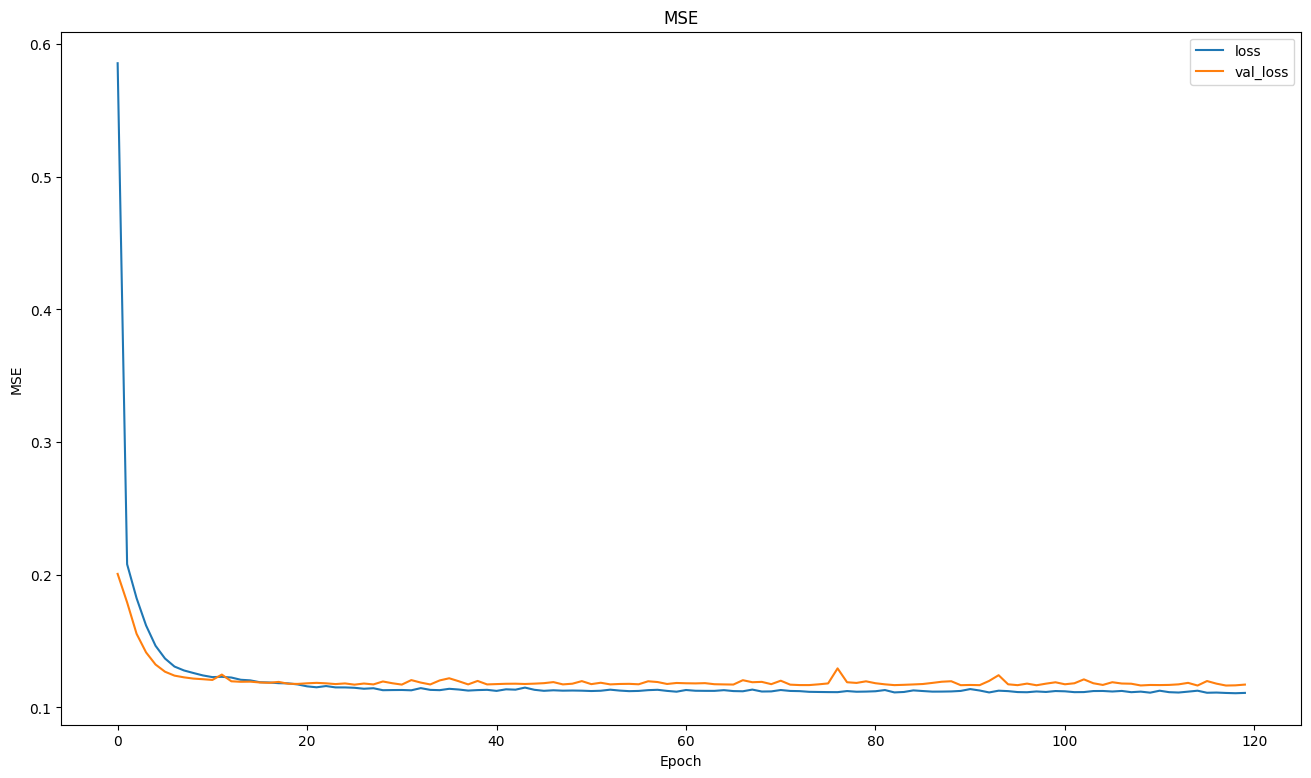

In [239]:
plot_mse()

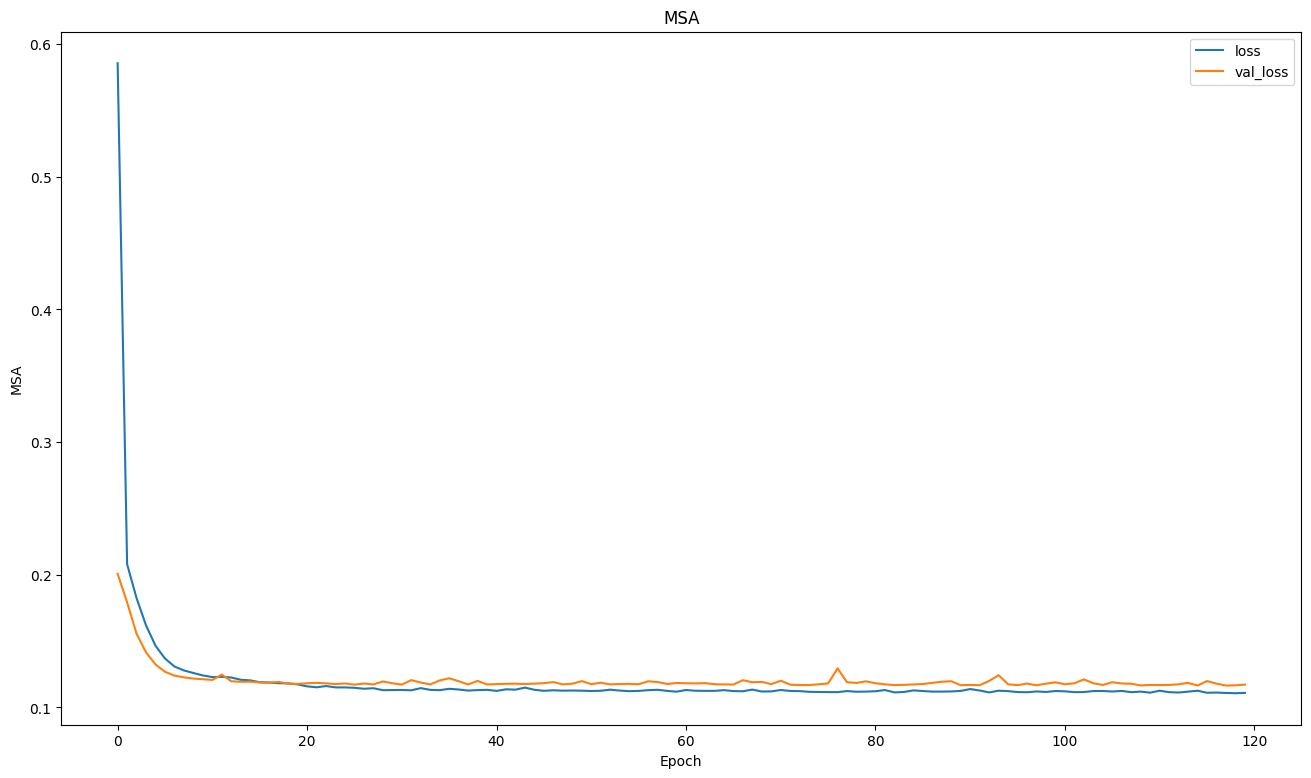

In [240]:
plot_msa()

14/14 [==============================] - 0s 1ms/step


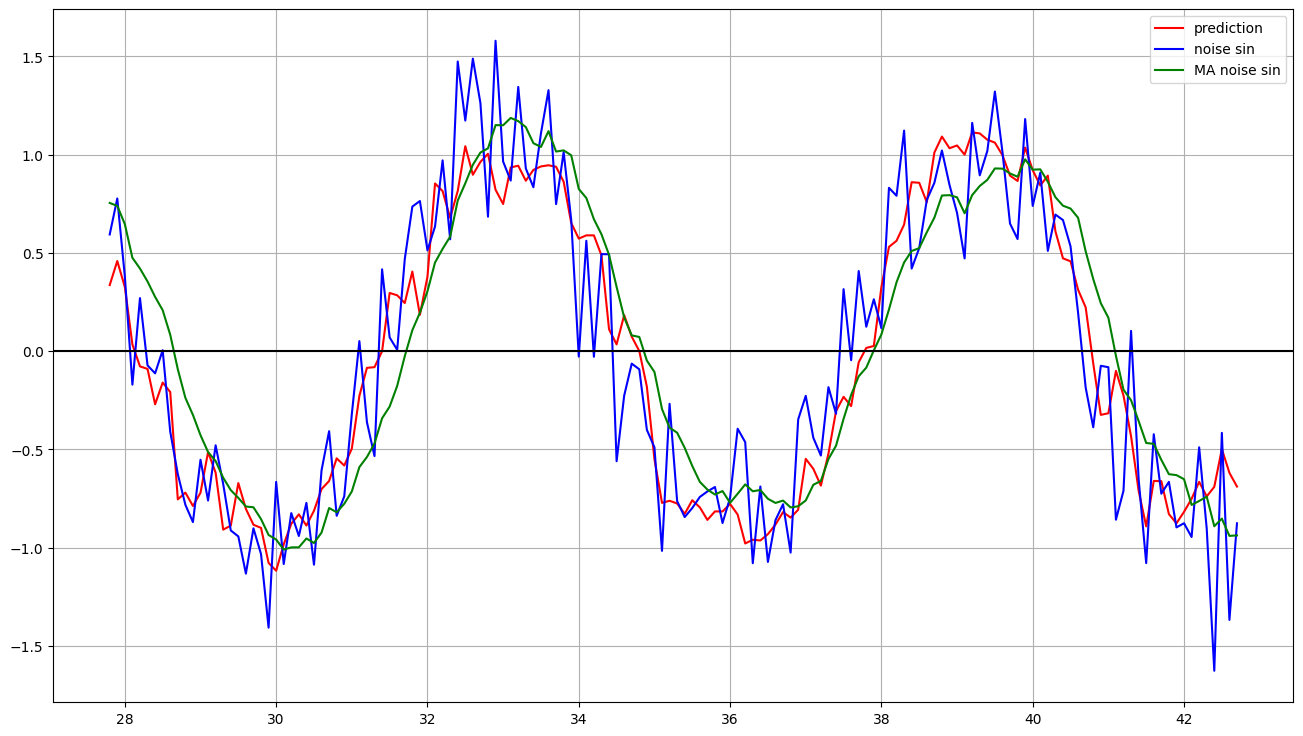

In [244]:
name = 'sin_with_noise_0_3'
type_model = 'RNN' 
show_pred(name, type_model)

### Модель RNN  для 'sin_with_noise_0_5'

In [253]:
model.evaluate(test_input, test_output)
model.save('model_RNN_'+name)

14/14 [==============================] - 0s 1ms/step - loss: 0.3127 - mean_absolute_error: 0.4481
INFO:tensorflow:Assets written to: model_RNN_sin_with_noise_0_5\assets


INFO:tensorflow:Assets written to: model_RNN_sin_with_noise_0_5\assets


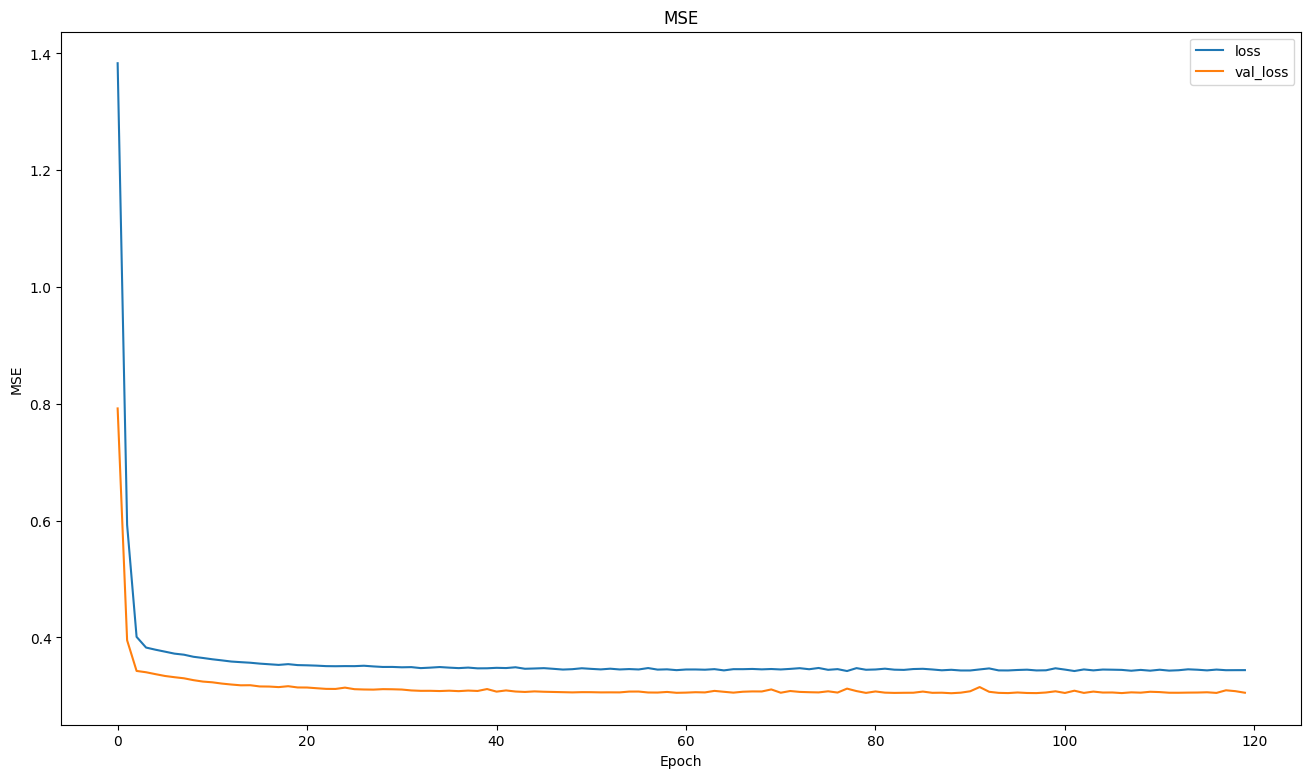

In [254]:
plot_mse()

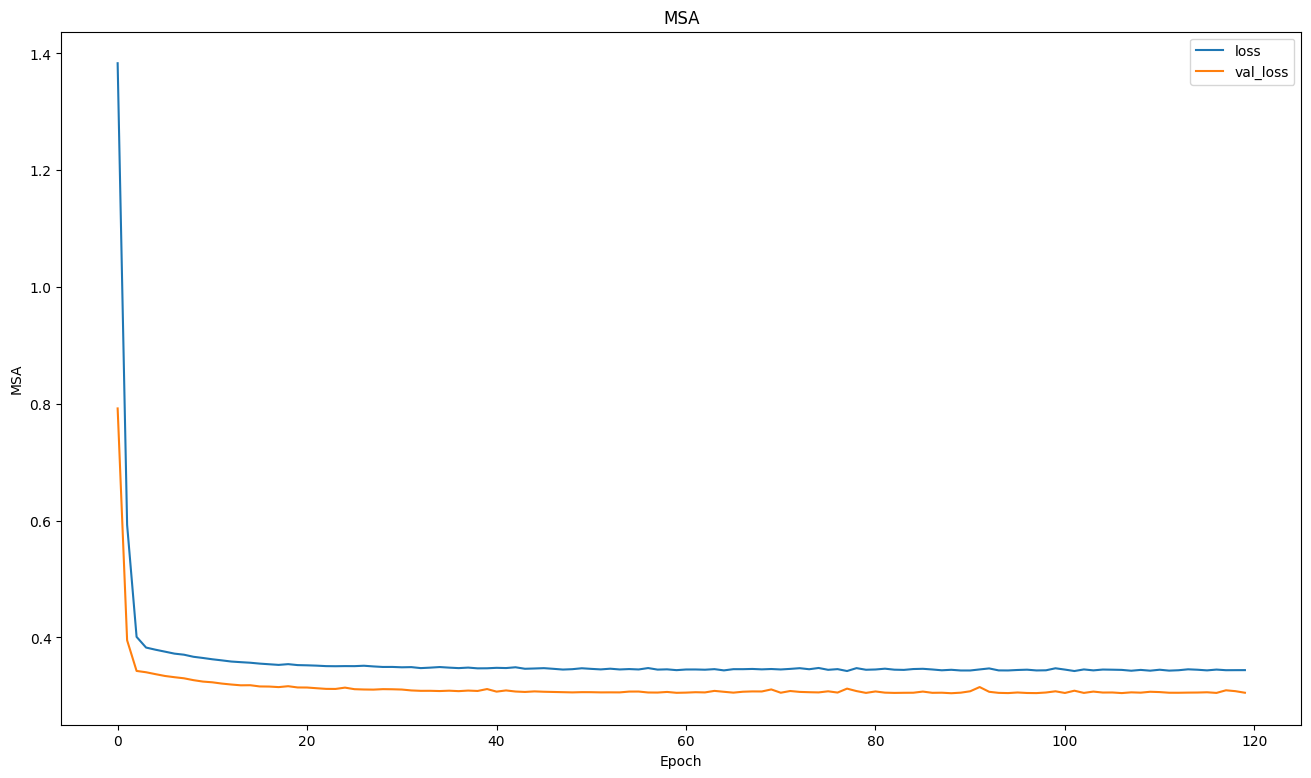

In [255]:
plot_msa()

14/14 [==============================] - 0s 1ms/step


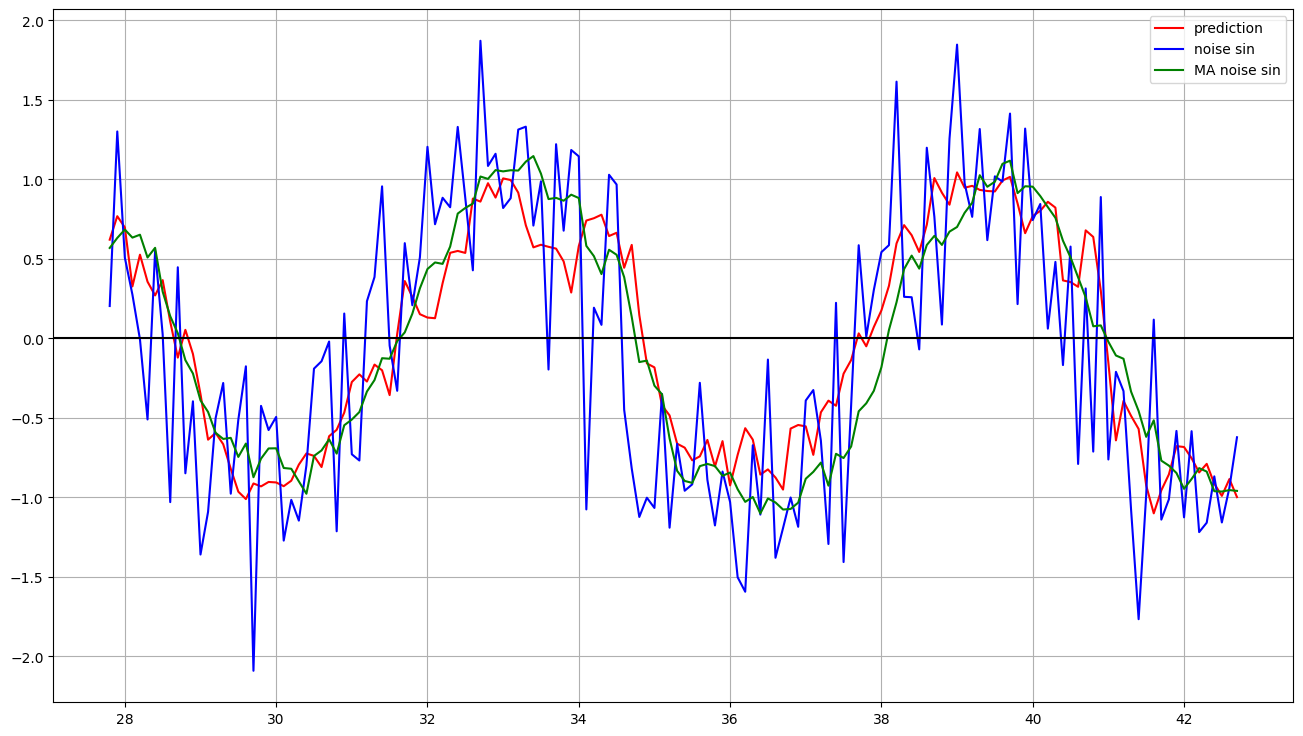

In [256]:
name = 'sin_with_noise_0_5'
type_model = 'RNN' 
show_pred(name, type_model)

#  ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤВыводы

1) По результатам можно сделать вывод, что при обучении RNN и LSTM моделей показатели обучения примерно одни и те же. Из предложенных моделей (а я уверен, что можно добиться и лучших результатов, если экспериментировать с Dense слоями и количеством нейронов) можно, для соответствующих шумов, выбрать одну из предложенных моделей, при этом они не будут кардинально различаться между собой.


2) Визуально предсказанные значения повторяют шум, пусть и с некоторой погрешностью. И чем меньше шум, тем меньше среднее расстояние от предсказанного значения до шума. И это вполне очевидно, ведь чем сильнее шум, тем больше разброс по оси y его значения. 

3) При увеличении шума модель все равно имеет способность предсказания

#  ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤДомашнее задание

Понимаю, это не вовремя, но все же это домашнее задание + мне было интересно. Про нормализацию нестационарных рядов еще позже почитаю

1) 5 моментов мат. стата: мат.ожидание, дисперсия, отклонения, корреляции, выборки

2. Как нормализовать нестационарный ряд? Например, через дифференцирование 
https://digitrain.ru/articles/34402/


3)

In [442]:
a = [1, 2, 3, 4, 5]
b = [6, 7, 8, 9, 10]

len(a) * (sum(a) +sum(b))

275

# Черновик

In [129]:
data = np.arange(81)
output_data = np.arange(81)
n = 8
data_ema = moving_avg(data, n)
data, output_data = data[n-1:], output_data[n-1:]

print("Исходные данные", '\n'+ str(data))
print("Соответствующие ema", '\n' + str(data_ema))
print("Массив будущих целевых данных output", '\n' + str(output_data))

Исходные данные 
[ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80]
Соответствующие ema 
[ 3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5
 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5 30.5
 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5 42.5 43.5 44.5
 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5 56.5 57.5 58.5
 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5 67.5 68.5 69.5 70.5 71.5 72.5
 73.5 74.5 75.5 76.5]
Массив будущих целевых данных output 
[ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80]


In [130]:
roll_1 = np.roll(data_ema, 1)
roll_2 = np.roll(data_ema, 2)
input_data = np.stack((roll_2, roll_1, data_ema), axis=1)

print("Для того, чтобы у нас была последовательность из ema n-2, ema n-1 и ema n создал переменные и сдвинул их вперёд, а потом объединил в вектор значений")
print("ema n-2,  ema n-1,  ema n,", '\n', input_data)

Для того, чтобы у нас была последовательность из ema n-2, ema n-1 и ema n создал переменные и сдвинул их вперёд, а потом объединил в вектор значений
ema n-2,  ema n-1,  ema n, 
 [[75.5 76.5  3.5]
 [76.5  3.5  4.5]
 [ 3.5  4.5  5.5]
 [ 4.5  5.5  6.5]
 [ 5.5  6.5  7.5]
 [ 6.5  7.5  8.5]
 [ 7.5  8.5  9.5]
 [ 8.5  9.5 10.5]
 [ 9.5 10.5 11.5]
 [10.5 11.5 12.5]
 [11.5 12.5 13.5]
 [12.5 13.5 14.5]
 [13.5 14.5 15.5]
 [14.5 15.5 16.5]
 [15.5 16.5 17.5]
 [16.5 17.5 18.5]
 [17.5 18.5 19.5]
 [18.5 19.5 20.5]
 [19.5 20.5 21.5]
 [20.5 21.5 22.5]
 [21.5 22.5 23.5]
 [22.5 23.5 24.5]
 [23.5 24.5 25.5]
 [24.5 25.5 26.5]
 [25.5 26.5 27.5]
 [26.5 27.5 28.5]
 [27.5 28.5 29.5]
 [28.5 29.5 30.5]
 [29.5 30.5 31.5]
 [30.5 31.5 32.5]
 [31.5 32.5 33.5]
 [32.5 33.5 34.5]
 [33.5 34.5 35.5]
 [34.5 35.5 36.5]
 [35.5 36.5 37.5]
 [36.5 37.5 38.5]
 [37.5 38.5 39.5]
 [38.5 39.5 40.5]
 [39.5 40.5 41.5]
 [40.5 41.5 42.5]
 [41.5 42.5 43.5]
 [42.5 43.5 44.5]
 [43.5 44.5 45.5]
 [44.5 45.5 46.5]
 [45.5 46.5 47.5]
 [46.5 47.5 

In [131]:
print("Так как в первые две строки попали значения с конца массива, то эти две строки надо удалить в input и output и вот что вышло после удаления")

input_data, output_data  = input_data[2:], output_data[2:]

print("ema n-2,  ema n-1,  ema n,", '\n', input_data, '\n')
print("output", '\n', output_data)
print("Так как значение 5.5 (элемент [0][3]) является значением скользящей для значения 9, то это значение скользящей должно быть входным параметром для предсказания значения 72. Что в свою очередь означает, что нужно свдинуть output на 63 элемента вперед (в моем примере предсказания будут на 63 элементов (2pi~6.3), тк один элемент это 0.1)")

output_data = output_data[63:]

print("Сдвинутый output_data" + "\n", output_data)
print("Теперь значения первой строки входного вектора соответствует значению, которое мы хотим предсказать")

Так как в первые две строки попали значения с конца массива, то эти две строки надо удалить в input и output и вот что вышло после удаления
ema n-2,  ema n-1,  ema n, 
 [[ 3.5  4.5  5.5]
 [ 4.5  5.5  6.5]
 [ 5.5  6.5  7.5]
 [ 6.5  7.5  8.5]
 [ 7.5  8.5  9.5]
 [ 8.5  9.5 10.5]
 [ 9.5 10.5 11.5]
 [10.5 11.5 12.5]
 [11.5 12.5 13.5]
 [12.5 13.5 14.5]
 [13.5 14.5 15.5]
 [14.5 15.5 16.5]
 [15.5 16.5 17.5]
 [16.5 17.5 18.5]
 [17.5 18.5 19.5]
 [18.5 19.5 20.5]
 [19.5 20.5 21.5]
 [20.5 21.5 22.5]
 [21.5 22.5 23.5]
 [22.5 23.5 24.5]
 [23.5 24.5 25.5]
 [24.5 25.5 26.5]
 [25.5 26.5 27.5]
 [26.5 27.5 28.5]
 [27.5 28.5 29.5]
 [28.5 29.5 30.5]
 [29.5 30.5 31.5]
 [30.5 31.5 32.5]
 [31.5 32.5 33.5]
 [32.5 33.5 34.5]
 [33.5 34.5 35.5]
 [34.5 35.5 36.5]
 [35.5 36.5 37.5]
 [36.5 37.5 38.5]
 [37.5 38.5 39.5]
 [38.5 39.5 40.5]
 [39.5 40.5 41.5]
 [40.5 41.5 42.5]
 [41.5 42.5 43.5]
 [42.5 43.5 44.5]
 [43.5 44.5 45.5]
 [44.5 45.5 46.5]
 [45.5 46.5 47.5]
 [46.5 47.5 48.5]
 [47.5 48.5 49.5]
 [48.5 49.5 50.5]
 [4

In [132]:
print("Но у массивов разная длина")
print( "Длина input "+str(len(input_data)), '\n',  "Длина output "+str(len(output_data)) )
print("Поэтому input тоже надо скоратить, только с конца")

input_data = input_data[:len(input_data)-63]

print("Теперь длина и элементы соответствуют друг другу")
print( "Длина input "+str(len(input_data)), '\n',  "Длина output "+str(len(output_data)) )
print("input", "\n", input_data)
print("output", "\n", output_data)

Но у массивов разная длина
Длина input 72 
 Длина output 9
Поэтому input тоже надо скоратить, только с конца
Теперь длина и элементы соответствуют друг другу
Длина input 9 
 Длина output 9
input 
 [[ 3.5  4.5  5.5]
 [ 4.5  5.5  6.5]
 [ 5.5  6.5  7.5]
 [ 6.5  7.5  8.5]
 [ 7.5  8.5  9.5]
 [ 8.5  9.5 10.5]
 [ 9.5 10.5 11.5]
 [10.5 11.5 12.5]
 [11.5 12.5 13.5]]
output 
 [72 73 74 75 76 77 78 79 80]
